# Assignment 5
Using UNSW_NB15_traintest_backdoor.csv available in Electronic Reserves, build a Fully Connected Neural Network in keras to classify rows as   anomaly or 0 normal  This dataset is not large and will not take long to train; therefore, your computers should be fine, and you should not be waiting long for results.
 
Follow the standard machine learning and data analysis steps we have used to date in the class to deliver a comprehensive notebook from EDA to final analysis.
 
Use any tools we have covered in the class as you feel best suits.
 
Tune your network and try to maximize classification perforance.  The architecture of the DNN is for you to design (layers, nodes, dr pouts, activation functions, epochs, tc.).  Describe how you went about this and what seemed to work best in a MARKDOWN cell – not as a comment in the 
ode.
 
The following will count 
s time -
Completeness - solid analysis.
Clarity – comment and explain!  Break code up so it is easy to see results as you progress through the project.
Neatness / organization – clean and readable visuals, load modules and data once, etc.


# Import libraries, load data, learn about the data and handle missing values

In [3]:
# Import all libraries
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
#from sklearn.svm import OneclassSVM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import precision_recall_fscore_support  # for calculating precision, recall, and F1-score

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow import keras
from tensorflow.keras import layers


import warnings
warnings.filterwarnings('ignore') #ignore warnings

%load_ext tensorboard

In [4]:
# Load the dataset using pandas
df = pd.read_csv('UNSW_NB15_traintest_backdoor.csv')
df.head()

,dur,proto=udp,proto=arp,proto=tcp,proto=igmp,proto=ospf,proto=sctp,proto=gre,proto=ggp,proto=ip,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,class
0,0.0,1,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.016129,0.0,0.0,0.0,0.000000,0.016393,0,0
1,0.0,1,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.016129,0.0,0.0,0.0,0.000000,0.016393,0,0
2,0.0,1,0,0,0,0,0,0,0,0,...,0.000000,0.0,0.032258,0.0,0.0,0.0,0.000000,0.032787,0,0
3,0.0,1,0,0,0,0,0,0,0,0,...,0.022222,0.0,0.032258,0.0,0.0,0.0,0.021739,0.032787,0,0
4,0.0,1,0,0,0,0,0,0,0,0,...,0.022222,0.0,0.032258,0.0,0.0,0.0,0.021739,0.032787,0,0


In [5]:
# Learning about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95329 entries, 0 to 95328
Columns: 197 entries, dur to class
dtypes: float64(38), int64(159)
memory usage: 143.3 MB


## Handling missing data if any

In [7]:
# obtaining columns with missing values
col = {}
cols = df.isnull().sum().to_dict()
for column, val in cols.items():
    if val > 0:
        col[column]=val
    else:
        pass
    
len(col)  

0

- No missig values in the dataset

# Data Visualization for insight

Text(0, 0.5, 'Frequency')

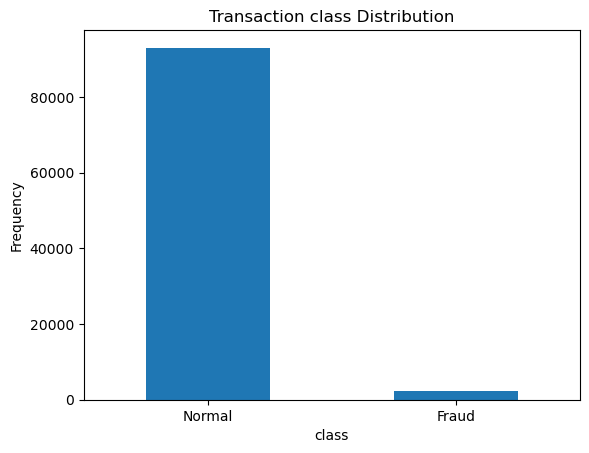

In [10]:
# A bar chat for 
LABELS = ["Normal", "Fraud"]
#count_classes = pd.value_counts(df['class'], sort = True)
count_classes = df['class'].value_counts(sort=True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("class")
plt.ylabel("Frequency")

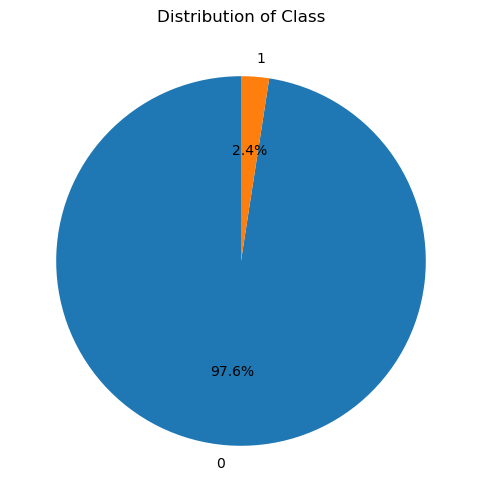

In [11]:
# Pie chart representation for the target class
LABELS = ["Normal", "Fraud"]
#count_classes = pd.value_counts(df['class'], sort = True)
count_classes = df['class'].value_counts(sort=True)
plt.figure(figsize=(8, 6))
plt.pie(count_classes, labels=count_classes.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Class')
plt.show()

In [12]:
# Count the number of normal vs fraud
df['class'].value_counts()

class
0    93000
1     2329
Name: count, dtype: int64

# Decriptive Analysis

In [14]:
# Descriptive Analysis
df.describe()

,dur,proto=udp,proto=arp,proto=tcp,proto=igmp,proto=ospf,proto=sctp,proto=gre,proto=ggp,proto=ip,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,class
count,95329.000000,95329.000000,95329.000000,95329.000000,95329.000000,95329.000000,95329.000000,95329.000000,95329.000000,95329.000000,...,95329.000000,95329.000000,95329.000000,95329.000000,95329.000000,95329.000000,95329.000000,95329.000000,95329.000000,95329.000000
mean,0.017416,0.231336,0.040344,0.705892,0.000504,0.002769,0.000724,0.000157,0.000073,0.000073,...,0.017742,0.004061,0.046951,0.006913,0.006955,0.008796,0.065176,0.074468,0.038582,0.024431
std,0.079187,0.421689,0.196767,0.455643,0.022434,0.052552,0.026894,0.012543,0.008569,0.008569,...,0.053285,0.035511,0.088506,0.058474,0.058916,0.040197,0.086517,0.094033,0.192598,0.154384
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000022,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021739,0.016393,0.000000,0.000000
50%,0.000831,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.016129,0.000000,0.000000,0.000000,0.043478,0.049180,0.000000,0.000000
75%,0.012360,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.022222,0.000000,0.048387,0.000000,0.000000,0.000000,0.086957,0.098361,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Performing EDA

In [16]:
# checking for correlation
df.corr()

,dur,proto=udp,proto=arp,proto=tcp,proto=igmp,proto=ospf,proto=sctp,proto=gre,proto=ggp,proto=ip,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,class
dur,1.000000,-0.111485,0.128621,0.010222,-0.004936,0.393393,0.010173,-0.002759,-0.001885,-0.001885,...,-0.008569,0.032070,0.043976,0.002015,0.002025,0.042784,0.007802,0.013170,0.079732,0.039290
proto=udp,-0.111485,1.000000,-0.112483,-0.849902,-0.012313,-0.028910,-0.014765,-0.006882,-0.004701,-0.004701,...,0.119861,0.047327,0.137058,-0.064857,-0.064761,-0.120043,0.077936,0.136039,-0.109898,-0.081337
proto=arp,0.128621,-0.112483,1.000000,-0.317651,-0.004602,-0.010805,-0.005518,-0.002572,-0.001757,-0.001757,...,-0.015288,0.056655,-0.084180,-0.024240,-0.024204,-0.044866,-0.122473,-0.137768,0.975358,-0.032447
proto=tcp,0.010222,-0.849902,-0.317651,1.000000,-0.034772,-0.081641,-0.041695,-0.019435,-0.013276,-0.013276,...,-0.123511,-0.117472,-0.101259,0.076311,0.076198,0.141243,-0.030746,-0.073082,-0.309634,-0.196998
proto=igmp,-0.004936,-0.012313,-0.004602,-0.034772,1.000000,-0.001183,-0.000604,-0.000282,-0.000192,-0.000192,...,0.002667,0.007968,-0.007646,-0.002653,-0.002650,-0.004911,-0.007626,-0.013699,-0.004496,-0.003552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ct_flw_http_mthd,0.042784,-0.120043,-0.044866,0.141243,-0.004911,-0.011531,-0.005889,-0.002745,-0.001875,-0.001875,...,-0.007435,0.043200,-0.040244,-0.025869,-0.025831,1.000000,-0.014829,-0.100370,-0.043835,-0.023324
ct_src_ltm,0.007802,0.077936,-0.122473,-0.030746,-0.007626,-0.021693,-0.006358,-0.004197,0.000004,-0.001534,...,0.578695,0.361747,0.458543,0.024422,0.024641,-0.014829,1.000000,0.442775,-0.119175,0.030330
ct_srv_dst,0.013170,0.136039,-0.137768,-0.073082,-0.013699,-0.032651,-0.017778,-0.002936,-0.003158,-0.004652,...,0.562782,0.246268,0.812002,-0.087730,-0.087512,-0.100370,0.442775,1.000000,-0.134111,0.008285
is_sm_ips_ports,0.079732,-0.109898,0.975358,-0.309634,-0.004496,-0.010557,-0.005391,-0.002513,-0.001717,-0.001717,...,-0.014026,0.056780,-0.081754,-0.023683,-0.023648,-0.043835,-0.119175,-0.134111,1.000000,-0.031702


## First of all we need to explain the positives and negatives associated with the numbers obtained.
- Positive Correlation; A positive correlation is a relationship between 2 variables which the increase of one variable causes an increase for another variable.
- Negative Correlation; The Negative correlation is the opposite, it’s a relationship between 2 variables which the increase of one variable causes a decrease for another variable. This applies otherwise.
- From our correlation analysis, we can see age has "dur" has a positive weak correlation with class of 0.039290. This means that as age increase the more likely there is a chance of heart attack and vice versa.
- We can also see that "proto=udp" has a weak negative correlation with class of -0.081337. This means that the lower the age the patient will not have more chance of a heat attack and vice versa.

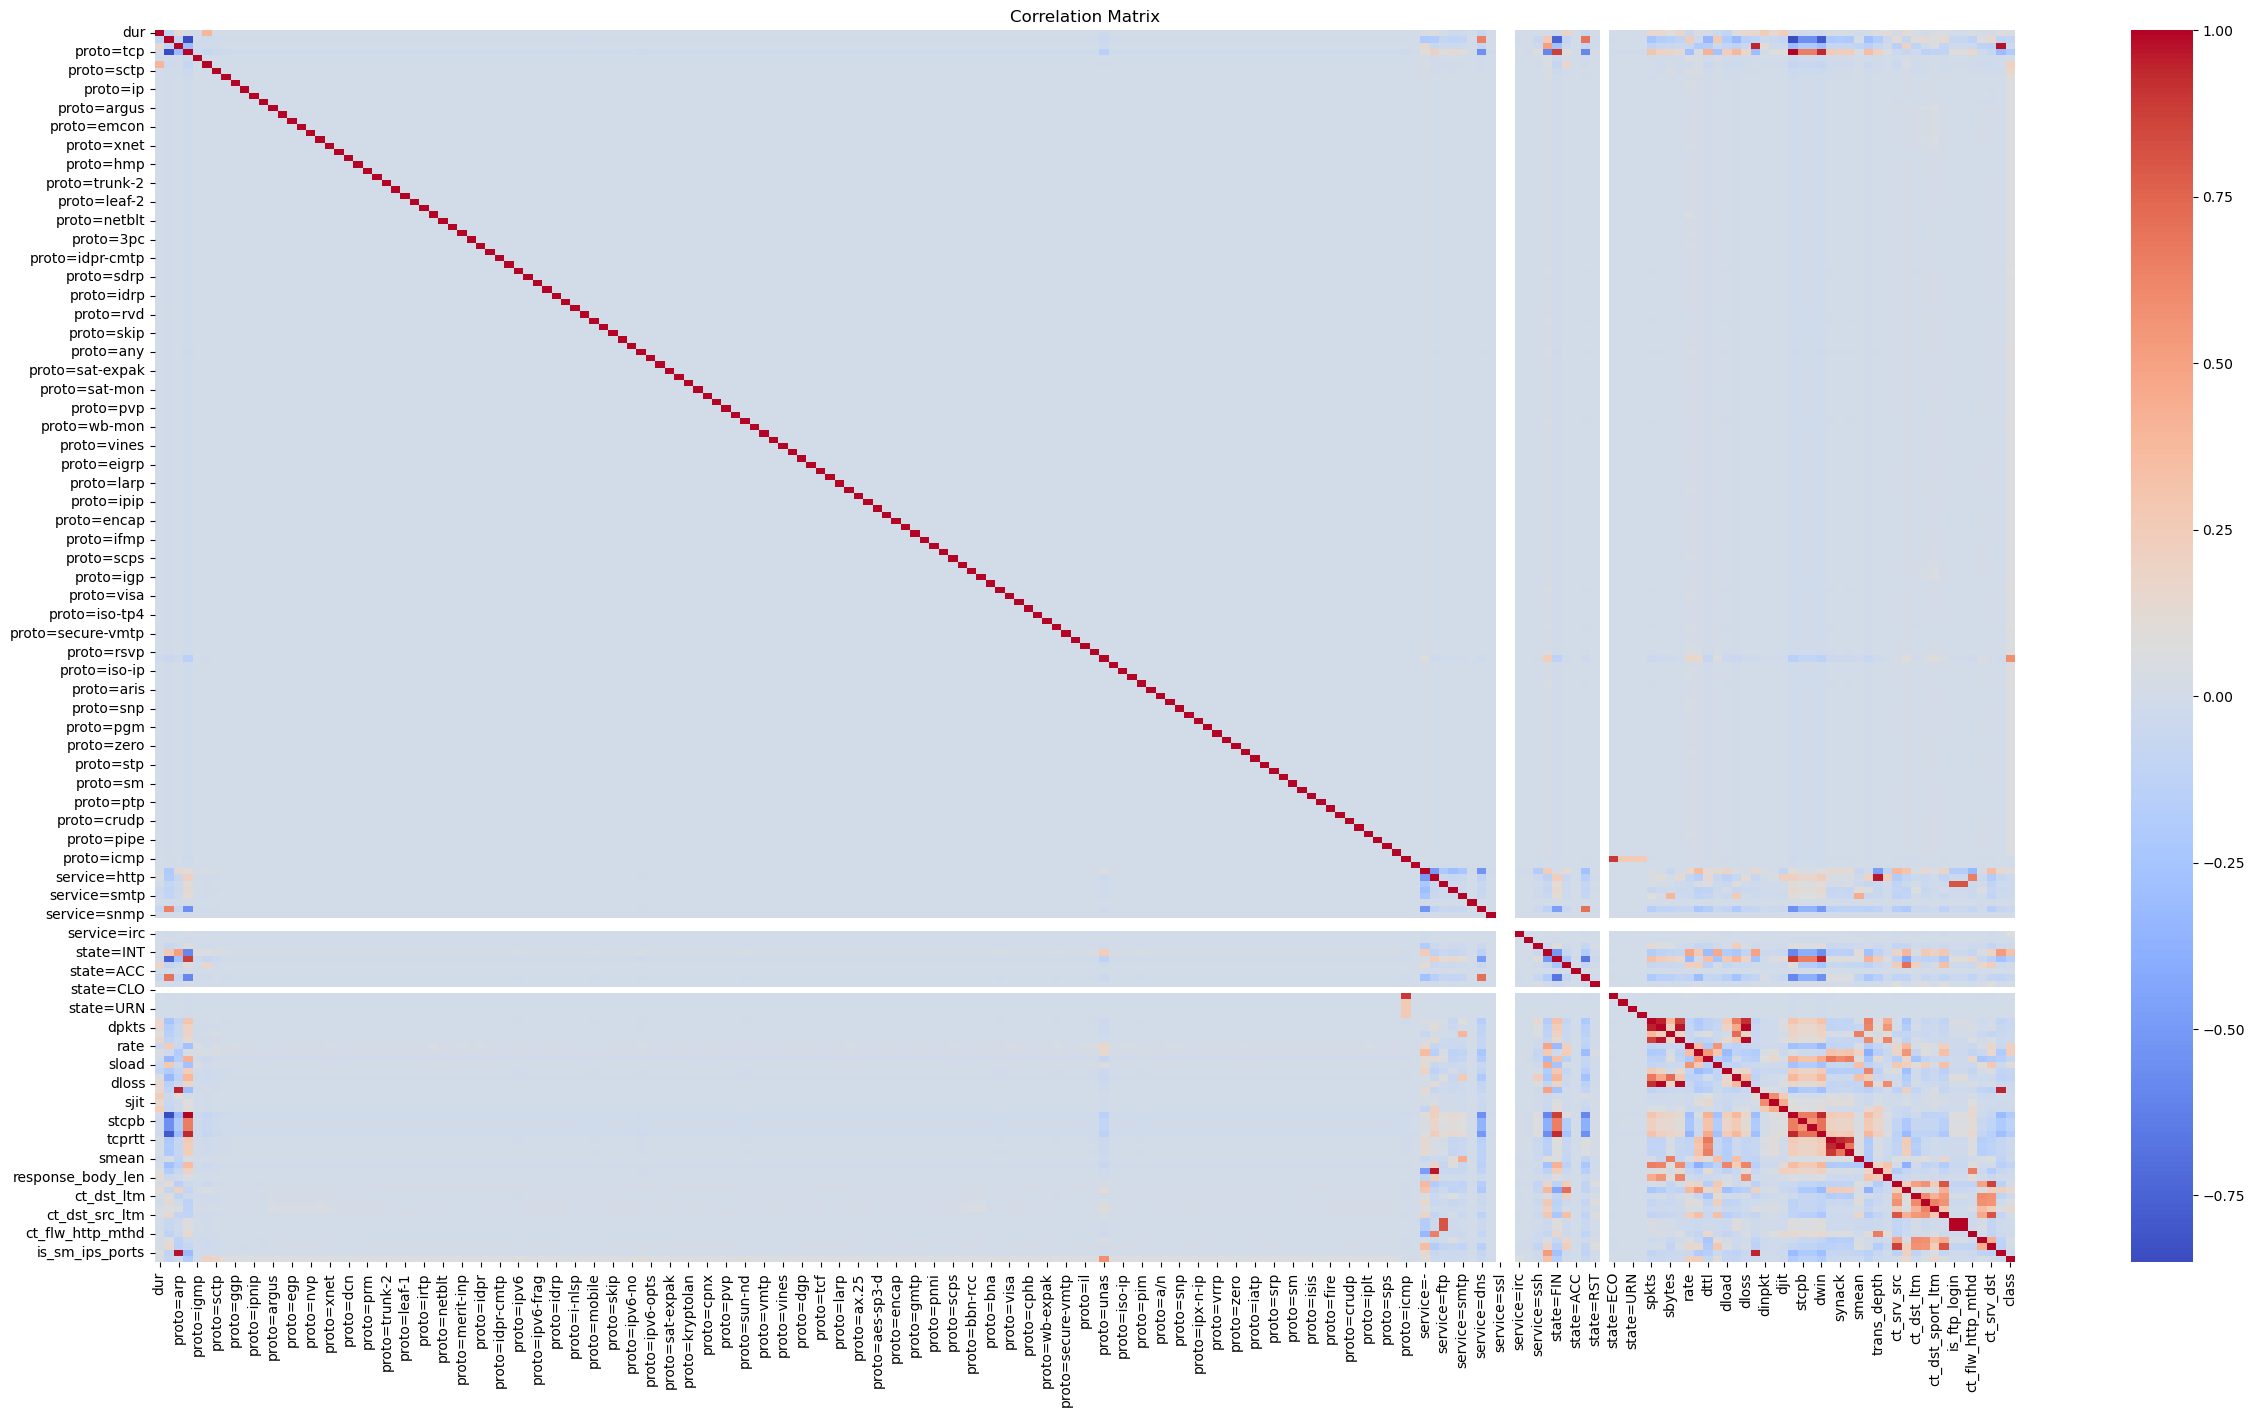

In [18]:
# prompt: correlation heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(30, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Statistical Inference

- Null hypothesis says two means are almost same.
- p-value is a probability if the null hypothesis is true. A high p-value (> 0.05) means we can't reject the null hypothesis
- Since we have a low p-value, we reject the null hypothesis that output and age are not the same

In [21]:
import pingouin as pg

# T-test for clients who is less likely or more likely in relation to age if their mean values are the same
no = df[df['class'] == 0]['dur']
yes = df[df['class'] == 1]['dur']

pg.ttest(no, yes, correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-12.140056,95327,two-sided,6.862813e-34,"[-0.02, -0.02]",0.254687,1.996e+30,1.0


In [22]:
# T-test for clients who is less likely or more likely in relation to age if their mean values are the same
no = df[df['class'] == 0]['proto=ggp']
yes = df[df['class'] == 1]['proto=ggp']

pg.ttest(no, yes, correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-16.743831,95327,two-sided,7.727304e-63,"[-0.0, -0.0]",0.35127,1.17e+59,1.0


## Feature Selection Using the P-Value to test for statistcal significance in place of PCA for dimensionality reduction.

- Null hypothesis: feature is statistically significant to the target variable
- Alternate hypothesis: feature is not satistically significant to the target variable
- p-value is a probability if the null hypothesis is true. A high p-value (> 0.05) means we reject the null hypothesis
- therefore any feature with a low p-value, we will fail to reject the null hypothesis.

In [25]:
### c. checking for p-value (TESTING FOR STATISTICAL SIGNIFICANCE OF INDEPENDENT VARIABLES)
import scipy.stats as stats
cl_corr = pd.DataFrame() # Correlation matrix
cl_p = pd.DataFrame() # Matrix of p-values
for x in df.columns:   # assuming cl as your dataframe name
   for y in df.columns:
      corr = stats.pearsonr(df[x], df[y])
      cl_corr.loc[x,y] = corr[0]
      cl_p.loc[x,y] = corr[1]

cl_p['class']

dur                  6.862813e-34
proto=udp           1.264761e-139
proto=arp            1.236002e-23
proto=tcp            0.000000e+00
proto=igmp           2.727934e-01
                        ...      
ct_flw_http_mthd     5.926437e-13
ct_src_ltm           7.488201e-21
ct_srv_dst           1.052860e-02
is_sm_ips_ports      1.239134e-22
class                0.000000e+00
Name: class, Length: 197, dtype: float64

In [26]:
# obtaining statistically significant variables
failed = []
passed = []
cols = cl_p['class'].to_dict()
for column, val in cols.items():
    if val > 0.05:
        failed.append({column : val})
    else:
        passed.append(column)
    
len(passed)
print("Failed:", failed)

Failed: [{'proto=igmp': 0.27279344286444995}, {'proto=icmp': 0.5399161632152122}, {'proto=rtp': 0.8742609074745125}, {'service=pop3': 0.7516213204346546}, {'service=snmp': 0.8742609074745125}, {'service=radius': 0.7516213204346546}, {'state=ACC': 0.8229140913611787}, {'state=RST': 0.17917792300669697}, {'state=ECO': 0.5835399829446655}, {'state=PAR': 0.8742609074745125}, {'state=URN': 0.8742609074745125}, {'state=no': 0.8742609074745125}]


- After calculating the p-value, feature "proto=igmp" (0.27279344286444995 > significant level 0.05) is not statistically significant to the target variable. There are 12 variables or features that are not statistically significant in total.
- But in the real-world some columns or features may not be statistically significant per p-value calculation but affects the target variable hugely. 

# Data pre-processing for model building

In [29]:
'''
The dataset is not balanced.  There are more normal transactions than fraudulent transactions.
'''

# Calculating the class imbalance
imbalance = (df['class'] == 1).sum() / ((df['class'] == 0).sum() + (df['class'] == 1).sum())
print(f"The class imbalance is {imbalance}")

The class imbalance is 0.02443118043827167


In [30]:
# Establishing the independent variables or features and dependent variable or target variable.
X = df.drop(columns = 'class')    # X represents features
y = df['class']                   # y is the target

X_p = df[passed] #for statistically significant variables 
#X_p = df.drop(columns = ['class', 'proto=igmp']) # taking out proto=igmp

# build a dictionary to save results
results = {}

## preparing data with all features with class imbalanced data

In [32]:
# Split data with 70% training dataset and 30% testing dataset
X_train_A, X_test_A, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #stratify retains the class balance - important for imbalnced data

In [33]:
# Rransform the split dataset
scaler = StandardScaler()
X_train_scaled_A = scaler.fit_transform(X_train_A)
X_test_scaled_A = scaler.transform(X_test_A) # do not fit transform the test set.  only transform.

## preparing data with statistically significant features with class imbalanced data

In [35]:
# Split data with 70% training dataset and 30% testing dataset
X_train, X_test, y_train, y_test = train_test_split(X_p, y, test_size=0.2, random_state=42, stratify=y) #stratify retains the class balance - important for imbalnced data

In [36]:
# Rransform the split dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # do not fit transform the test set.  only transform.

When one scales the whole dataset, the minimum and maximum values used to calculate the scaling parameters thus the mean and standard deviation will include information from both the training and testing sets. This means the training data is inadvertently using information from the test set to scale itself, which is not ideal for accurate evaluation.
By incorporating information from the test set into the scaling process, your model might learn patterns specific to the test data, leading to overfitting and poor performance on unseen data.

# Model Building and Tunning
- We are choosing the Tensorflow keras Framework which gives us the opportunity to investigate overfitting with plotting
- In building the model, I chose five layers starting with 64 nodes, 32, 16 and dropout of 0.5 and 1 respectively. The input shape which corresponds to the number feautures is decided based on the statistically significant features and all features. The activation function I chose is "relu" and the output activation function is sigmoid since this a binary classification problem or model. I started with 10 number of training iteration (epochs) then increased it to 100 to achieve a good accuracy.
- When compiling the model, the learning rate or optimizer chosen is "adam", the loss function is "binary crossentopy" since we have a binary classification problem and the metrics is "binary accuracy".

### Building a DNN model with Tensorflow with all features and class imbalanced data

In [40]:
# Build a simple tensorflow model with five layers
def build_model_all():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[196]),
    layers.Dense(32, activation='relu'), 
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),    
    layers.Dense(1, activation='sigmoid'),
    ])
    
    # compile the model with a loss function and optimizer
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )
    
    return model

# Call the build model function
model_all = build_model_all()

# Build the model with the optimal hyperparameters and train it on the data for 1000 epochs
history = model_all.fit(
    X_train_scaled_A, y_train,
    validation_split=0.2,
    #validation_data=(X_test, y_test),
    batch_size=512,
    epochs=100,
    #callbacks=[early_stopping],
    verbose=0, # 0 to hide the output because we have so many epochs
)

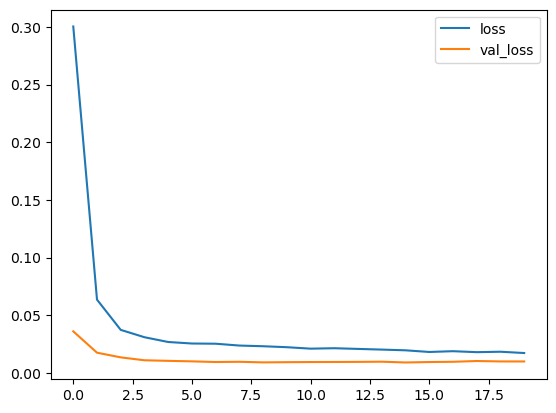

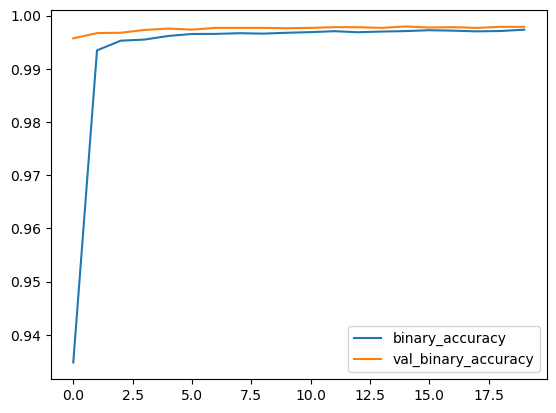

In [41]:
# plotting validation to check for overfitting
def plot_val(history):
    history_df = pd.DataFrame(history.history)
    # Start the plot at epoch 5
    history_df.loc[0:19, ['loss', 'val_loss']].plot()
    history_df.loc[0:19, ['binary_accuracy', 'val_binary_accuracy']].plot()
plot_val(history)

In [42]:
# prediction with X_test
Y_pred_nn = model_all.predict(X_test_scaled_A)
rounded = [round(x[0]) for x in Y_pred_nn]
Y_pred_nn = rounded
score_nn = round(accuracy_score(Y_pred_nn,y_test)*100,2)
print("The accuracy score achieved using Neural Network is: "+str(score_nn)+" %")

596/596 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
The accuracy score achieved using Neural Network is: 99.76 %


#### Model Evaluation

In [44]:
# Calculating Precision, Recall, and F1-score for each class using Y_test and Y_pred
precision, recall, f1measure, support = precision_recall_fscore_support(y_test, Y_pred_nn, average='weighted')
f1 = f1_score(y_test, Y_pred_nn, average='weighted')
results["model_with_all_features_&_class_imbalance"]=[score_nn, precision, recall, f1measure, f1]
print (precision)
print (recall)
print (f1measure)

0.9976328438701889
0.9976397776146019
0.9976360618691352


<Axes: >

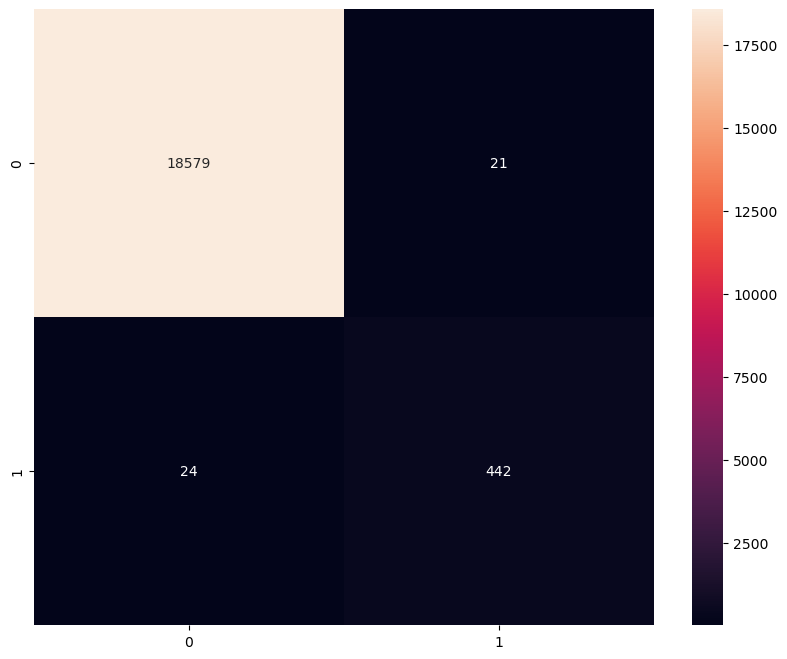

In [45]:
# Confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_test, Y_pred_nn)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

In [46]:
# A fountion to plot roc
def plot_roc_(y_test, Y_pred_nn):
    fpr, tpr, _ = roc_curve(y_test, Y_pred_nn)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

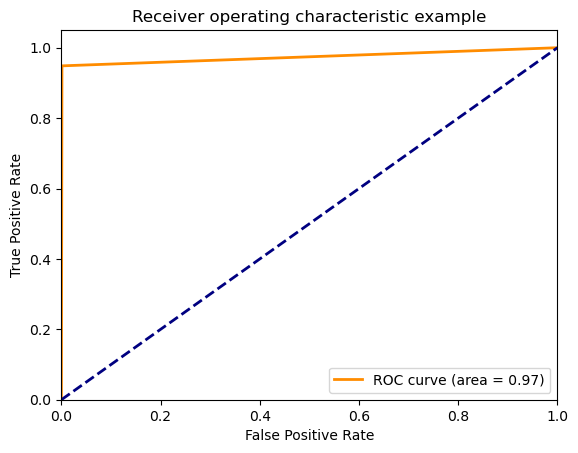

In [47]:
# plot roc
plot_roc_(y_test, Y_pred_nn)

### Building a DNN model with Tensorflow with statistically significant variables and class imbalanced data

In [49]:
# Build a simple tensorflow model with five layers
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[185]),
    layers.Dense(32, activation='relu'), 
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),    
    layers.Dense(1, activation='sigmoid'),
    ])
    
    # compile the model with a loss function and optimizer
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],
    )
    
    return model

# Call the build model function
model = build_model()

# Build the model with the optimal hyperparameters and train it on the data for 1000 epochs
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    #validation_data=(X_test, y_test),
    batch_size=512,
    epochs=100,
    #callbacks=[early_stopping],
    verbose=0, # 0 to hide the output because we have so many epochs
)

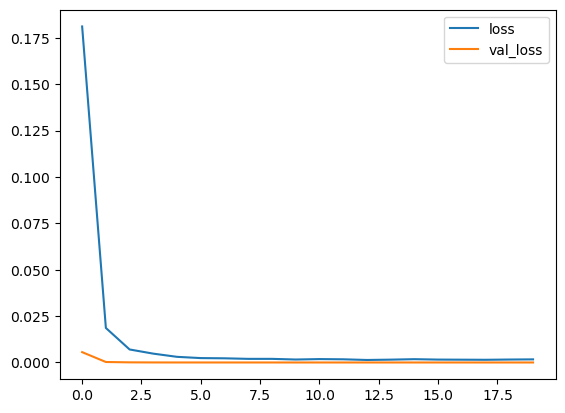

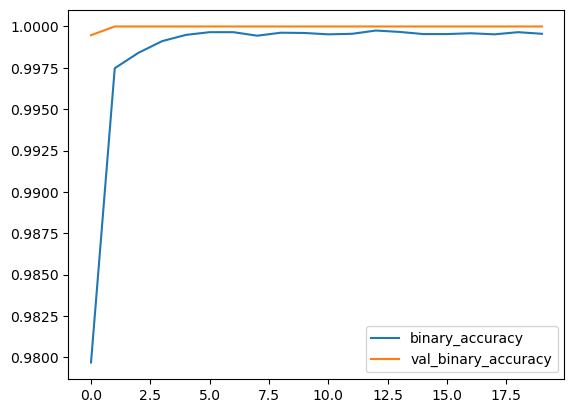

In [50]:
# plotting validation to check for overfitting
plot_val(history)

In [51]:
# prediction with X_test
Y_pred_nn = model.predict(X_test_scaled)

rounded = [round(x[0]) for x in Y_pred_nn]
Y_pred_nn = rounded

score_nn = round(accuracy_score(Y_pred_nn,y_test)*100,2)

print("The accuracy score achieved using Neural Network is: "+str(score_nn)+" %")

596/596 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
The accuracy score achieved using Neural Network is: 100.0 %


## Model Evaluation

In [53]:
# Calculating Precision, Recall, and F1-score for each class using Y_test and Y_pred
precision, recall, f1measure, support = precision_recall_fscore_support(y_test, Y_pred_nn, average='weighted')
f1 = f1_score(y_test, Y_pred_nn, average='weighted')
results["model_with_statistically_significant_features_&_class_imbalance"] =[score_nn, precision, recall, f1measure, f1]
print (precision)
print (recall)
print (f1measure)

1.0
1.0
1.0


<Axes: >

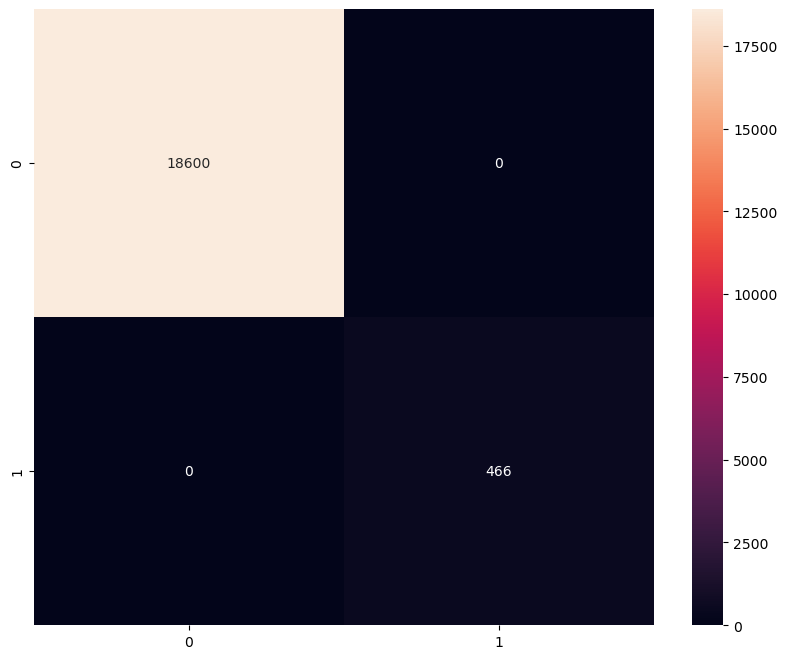

In [54]:
# Confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_test, Y_pred_nn)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

#### ROC Curve

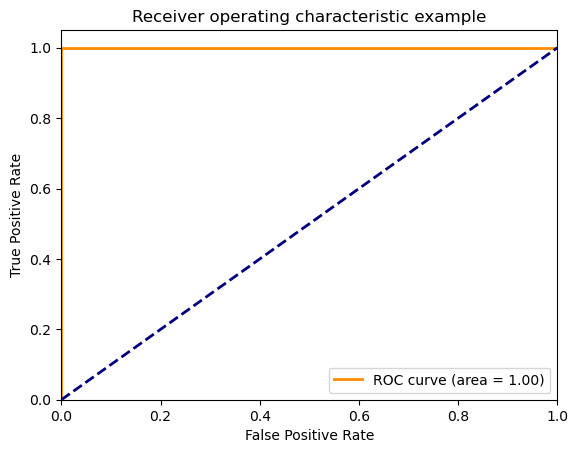

In [56]:
# plot roc
plot_roc_(y_test, Y_pred_nn)

# Next we build a model and fixing the class imbalance using Randon Over Sampler with statistically significant variables

In [58]:
# check version number
from imblearn.over_sampling import RandomOverSampler

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_p, y)  # when X_p is the statistically significant features

# Split data with 70% training dataset and 30% testing dataset and taking out the stratify technique
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

# Rransform the split dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # do not fit transform the test set.  only transform.

# Build the model with the optimal hyperparameters and train it on the data for 1000 epochs
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    #validation_data=(X_test, y_test),
    batch_size=512,
    epochs=100,
    #callbacks=[early_stopping],
    verbose=0, # 0 to hide the output because we have so many epochs
)

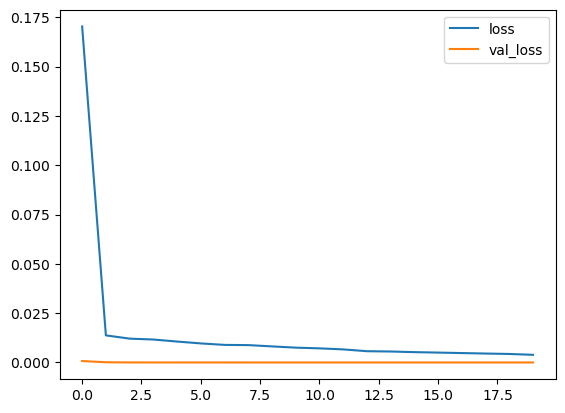

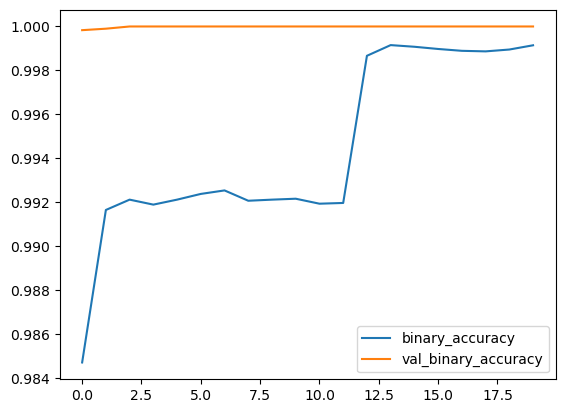

In [59]:
# plotting validation to check for overfitting
plot_val(history)

- Looking at the loss, loss validation plot and validation accuracy, accuracy, we can see that each pair are closer in the loss calculation and prediction accuracy compared the imbalanced dataset. Hence, solving using Random Oversampling technique with the minority strategy worked better than the imbalanced dataset.

In [61]:
# prediction with X_test
Y_pred_nn = model.predict(X_test_scaled)
rounded = [round(x[0]) for x in Y_pred_nn]
Y_pred_nn = rounded
score_nn = round(accuracy_score(Y_pred_nn,y_test)*100,2)

# Update the results
#results["statistical significant accuracy"] = score_nn
print("The accuracy score achieved using Neural Network is: "+str(score_nn)+" %")

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
The accuracy score achieved using Neural Network is: 100.0 %


## Model Evaluation

In [63]:
# Calculating Precision, Recall, and F1-score for each class using Y_test and Y_pred
precision, recall, f1measure, support = precision_recall_fscore_support(y_test, Y_pred_nn, average='weighted')
f1 = f1_score(y_test, Y_pred_nn, average='weighted')
results["model_with_statistically_significant_features_&_balanced_class"] =[score_nn, precision, recall, f1measure, f1]
# results["statistical significant precision"] = precision
# results["statistical significant recall"] = recall
# results["statistical significant f1measure"] = f1measure
print (precision)
print (recall)
print (f1measure)

1.0
1.0
1.0


<Axes: >

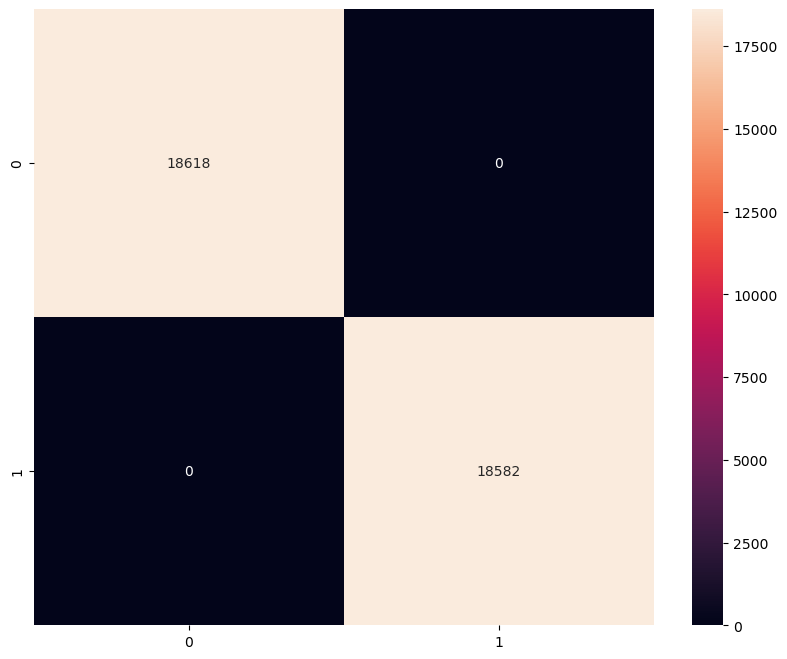

In [64]:
# Confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_test, Y_pred_nn)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

## Plot ROC

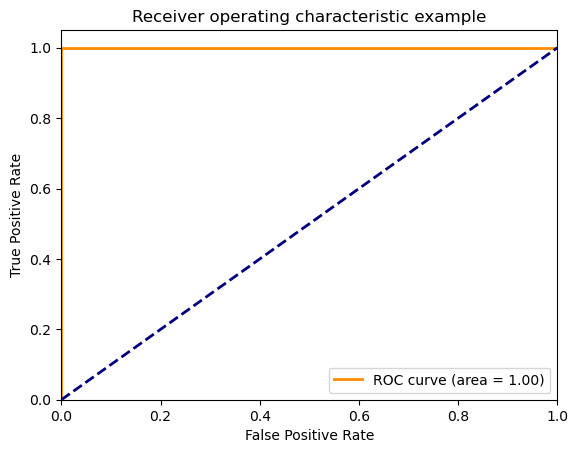

In [66]:
# plot roc
plot_roc_(y_test, Y_pred_nn)

# Build a model that deals with class imbalance with all Variables or features

In [68]:
# check version number
from imblearn.over_sampling import RandomOverSampler

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)

# Split data with 70% training dataset and 30% testing dataset and taking out the stratify technique
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

# Rransform the split dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # do not fit transform the test set.  only transform.

# Build the model with the optimal hyperparameters and train it on the data for 1000 epochs
history = model_all.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    #validation_data=(X_test, y_test),
    batch_size=512,
    epochs=100,
    #callbacks=[early_stopping],
    verbose=0, # 0 to hide the output because we have so many epochs
)

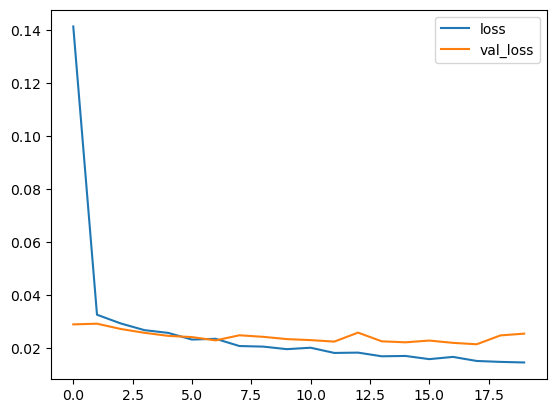

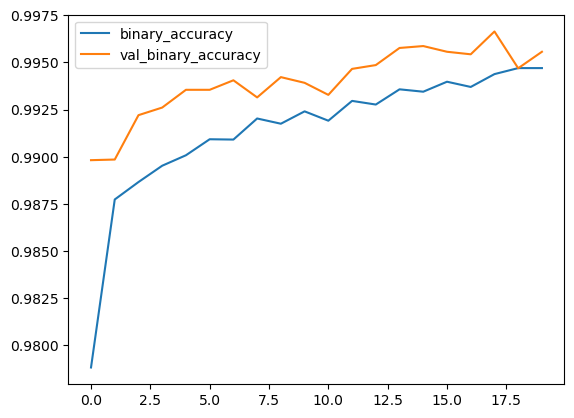

In [69]:
# plotting validation to check for overfitting
plot_val(history)

- Looking at the loss, loss validation plot and validation accuracy, accuracy, we can see that validation accuracy and accuracy are not closer in the prediction accuracy compared the model with all features with balanced class. Hence, solving using Random Oversampling technique with the minority strategy worked better than the imbalanced dataset.

In [71]:
# prediction with X_test
Y_pred_nn = model_all.predict(X_test_scaled)

# Prediction accuracy
rounded = [round(x[0]) for x in Y_pred_nn]
Y_pred_nn = rounded
score_nn = round(accuracy_score(Y_pred_nn,y_test)*100,2)
#results["not statistical significant accuracy"] = score_nn
print("The accuracy score achieved using Neural Network is: "+str(score_nn)+" %")

1163/1163 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
The accuracy score achieved using Neural Network is: 99.95 %


## Model Evaluation

In [73]:
# Calculating Precision, Recall, and F1-score for each class using Y_test and Y_pred
precision, recall, f1measure, support = precision_recall_fscore_support(y_test, Y_pred_nn, average='weighted')
f1 = f1_score(y_test, Y_pred_nn, average='weighted')
results["model_with_all_features_&_balanced_class"] = [score_nn, precision, recall, f1measure, f1] 
# results["not statistical significant recall"] = recall
# results["not statistical significant f1measure"] = f1measure
print (precision)
print (recall)
print (f1measure)

0.9994629436307576
0.9994623655913979
0.9994623657157207


<Axes: >

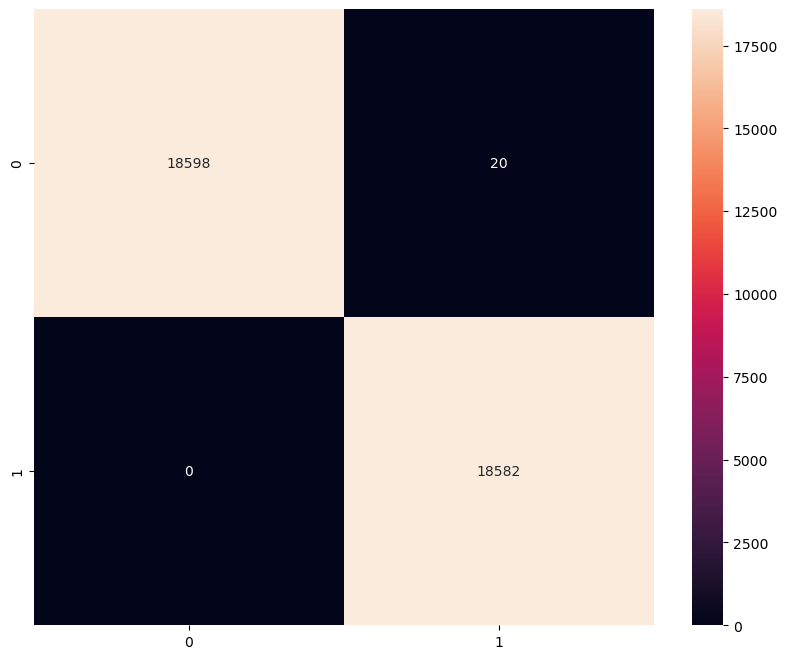

In [74]:
# Confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_test, Y_pred_nn)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

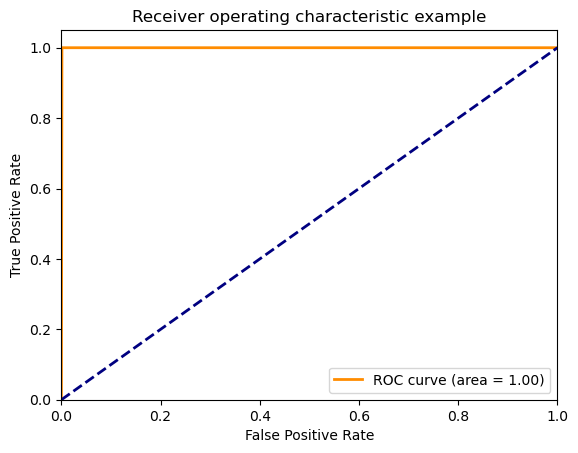

In [75]:
# plot roc
plot_roc_(y_test, Y_pred_nn)

# Final Analysis and Model Selection

In [77]:
# Evaluation Metrics results for model
metrics_results = pd.DataFrame(results, index=["accuracy", "precision", "recall", "f1measure", "f1_score"])
metrics_results.T

,accuracy,precision,recall,f1measure,f1_score
model_with_all_features_&_class_imbalance,99.76,0.997633,0.997640,0.997636,0.997636
model_with_statistically_significant_features_&_class_imbalance,100.00,1.000000,1.000000,1.000000,1.000000
model_with_statistically_significant_features_&_balanced_class,100.00,1.000000,1.000000,1.000000,1.000000
model_with_all_features_&_balanced_class,99.95,0.999463,0.999462,0.999462,0.999462


- Comparing the models built and evaluated based on accuracy, precision, recall and f1score results, we can vividly see that models built with statistically significant feautures got higher accuracy, precision, recall and f1score than models built with all features for both class imbalanced and class balanced data.
- With the confusion matrix, statistically significant models gave no Type I and Type II Errors as compared to models with all features employed.
- And so was the same for Area Under Curve from plotting the ROC, statistically significant built models came up on top.
- Hence, feature selection in model building is significant to model performance. 